Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(r"C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Train")
data_dir_test = pathlib.Path(r'C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#train_ds = ##todo
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array


train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 7153 files belonging to 9 classes.
Using 5723 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#val_ds = ##todo

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 118 files belonging to 9 classes.
Using 23 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# We have 9 classes in total

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

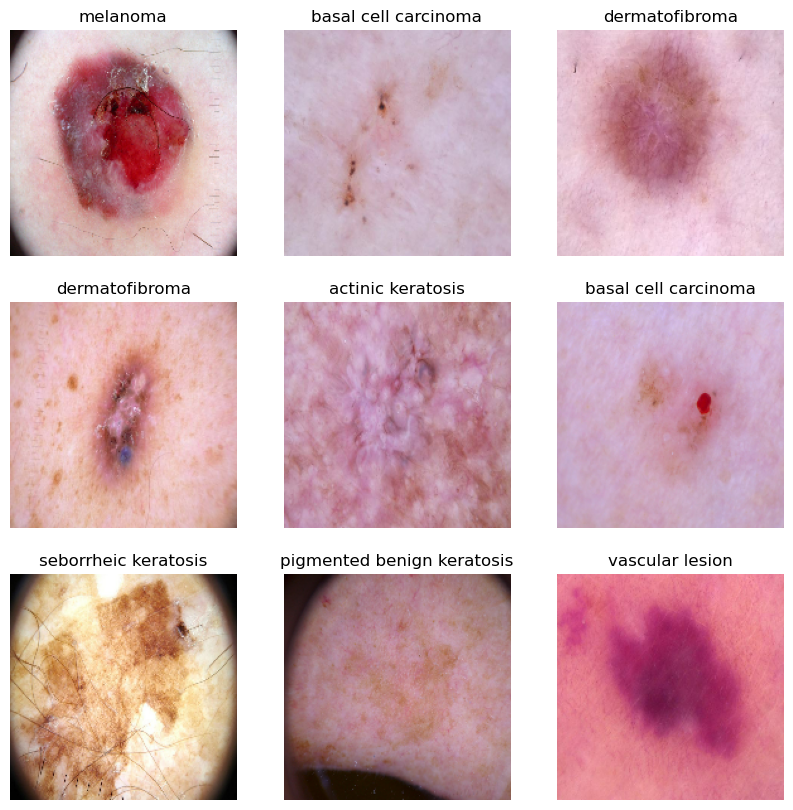

In [9]:


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)


### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(len(class_names))
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


C:\upGrad\PythonLearn\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

None


In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 88s 330ms/step - accuracy: 0.1487 - loss: 2.3683 - val_accuracy: 0.1739 - val_loss: 2.1347
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 308ms/step - accuracy: 0.3995 - loss: 1.5630 - val_accuracy: 0.3913 - val_loss: 2.0252
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 304ms/step - accuracy: 0.4791 - loss: 1.3782 - val_accuracy: 0.2174 - val_loss: 2.5045
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 306ms/step - accuracy: 0.5490 - loss: 1.2078 - val_accuracy: 0.2609 - val_loss: 2.7666
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 307ms/step - accuracy: 0.5930 - loss: 1.1052 - val_accuracy: 0.3043 - val_loss: 2.9677
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 304ms/step - accuracy: 0.6479 - loss: 0.9498 - val_accuracy: 0.1739 - val_loss: 3.1916
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 55s 308ms/step - accuracy: 0.7018 - loss: 0.8337 - val_accuracy: 0.1739 - val_loss: 3.5390
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 56s 312ms/step - accuracy: 0.7469 - loss: 0

### Compile the model
Choose an appropirate optimiser and loss function for model training 

### Train the model

### Visualizing training results

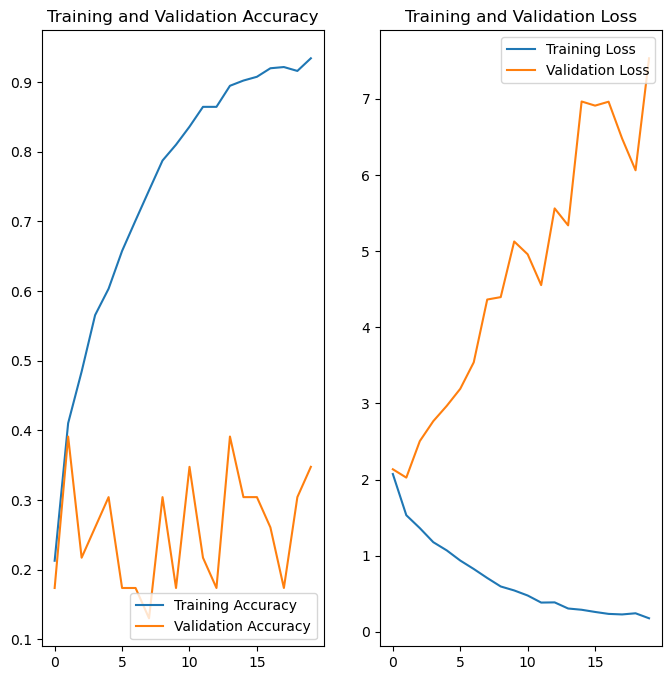

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [16]:
## There is huge difference b/w Training Accuracy & Validation Accuracy & increasing validation loss indicates overfitting of dataset.
# Below is  another model using BatchNormalization

In [17]:
# Model num: 2 : BatchNormalization() is added to the previous model

In [18]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(len(class_names))
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 71s 355ms/step - accuracy: 0.3820 - loss: 1.8253 - val_accuracy: 0.1739 - val_loss: 2.2256
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 63s 354ms/step - accuracy: 0.6273 - loss: 1.0760 - val_accuracy: 0.1739 - val_loss: 2.0448
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 63s 352ms/step - accuracy: 0.7033 - loss: 0.8556 - val_accuracy: 0.2609 - val_loss: 2.3972
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 358ms/step - accuracy: 0.8081 - loss: 0.5929 - val_accuracy: 0.1739 - val_loss: 3.5926
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 63s 352ms/step - accuracy: 0.8565 - loss: 0.4381 - val_accuracy: 0.1739 - val_loss: 3.2992
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 63s 354ms/step - accuracy: 0.8561 - loss: 0.4502 - val_accuracy: 0.2174 - val_loss: 5.1170
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 359ms/step - accuracy: 0.9470 - loss: 0.2002 - val_accuracy: 0.4348 - val_loss: 4.0061
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 64s 358ms/step - accuracy: 0.9645 - loss: 0

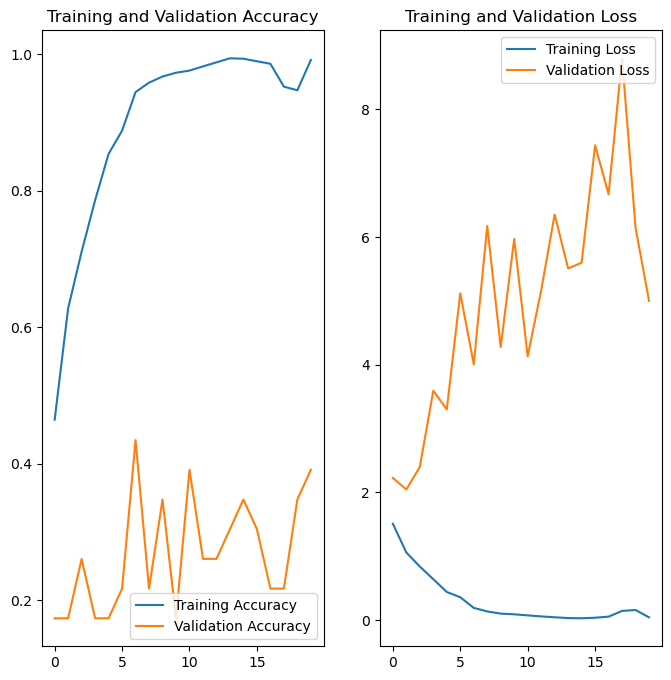

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [22]:
## There is huge difference b/w Training Accuracy & Validation Accuracy & increasing validation loss indicates overfitting of dataset.

### Write your findings here

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.RandomCrop(img_height,img_width),
  ]
)

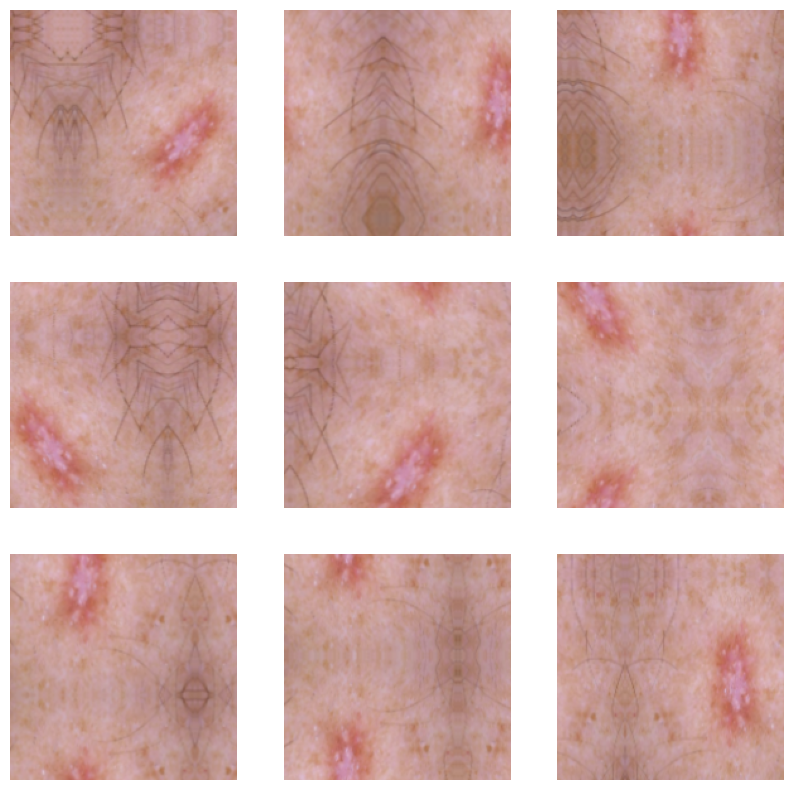

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes hermodel2.compile(optimizer='sgd',loss='sparse_categorical_crossentropy',metrics=['accuracy'])## You can use Dropout layer if there is an evidence of overfitting in your findings




In [26]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

### Compiling the model

In [27]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - accuracy: 0.1841 - loss: 2.2244 - val_accuracy: 0.1739 - val_loss: 2.0705
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 352s 2s/step - accuracy: 0.2769 - loss: 1.8090 - val_accuracy: 0.0435 - val_loss: 2.1951
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.3118 - loss: 1.7617 - val_accuracy: 0.1739 - val_loss: 2.3576
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 343s 2s/step - accuracy: 0.3423 - loss: 1.6773 - val_accuracy: 0.2174 - val_loss: 2.1356
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - accuracy: 0.3992 - loss: 1.6032 - val_accuracy: 0.1739 - val_loss: 2.3046
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.4226 - loss: 1.5432 - val_accuracy: 0.2174 - val_loss: 1.9986
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 385s 2s/step - accuracy: 0.4213 - loss: 1.5207 - val_accuracy: 0.2174 - val_loss: 2.4120
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.4284 - loss: 1.5035 - val_accu

### Visualizing the results

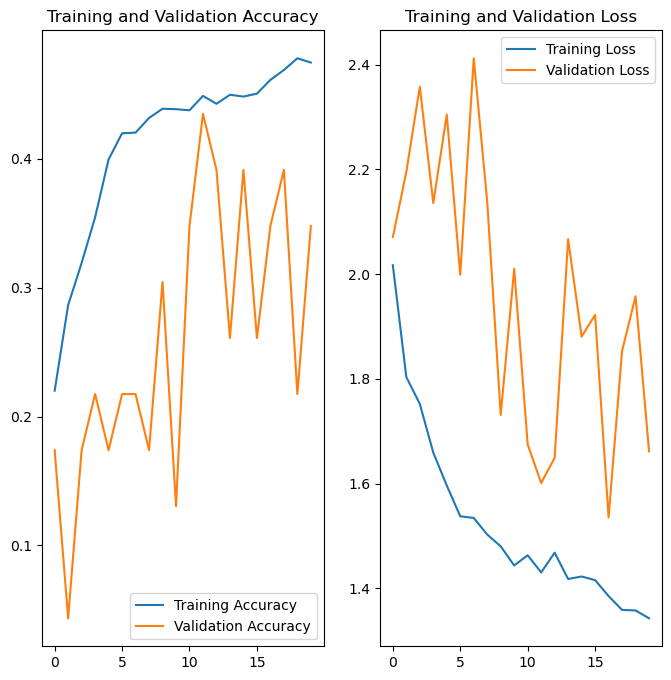

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [30]:
## Your code goes here.
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [31]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Trai...,actinic keratosis
1,C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Trai...,actinic keratosis
2,C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Trai...,actinic keratosis
3,C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Trai...,actinic keratosis
4,C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Trai...,actinic keratosis
...,...,...
2234,C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Trai...,vascular lesion
2235,C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Trai...,vascular lesion
2236,C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Trai...,vascular lesion
2237,C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Trai...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


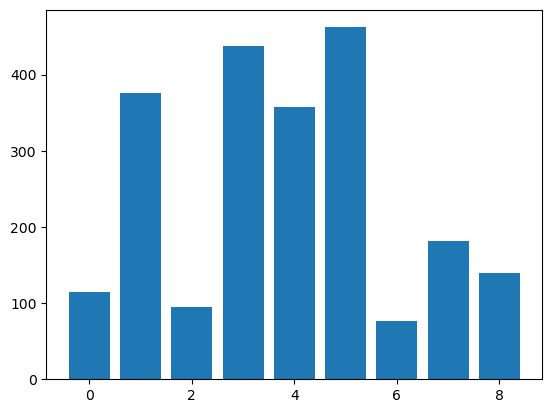

In [32]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? : Class 2 i.e seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples? Class 5 i.e pigmented benign keratosis

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [33]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [34]:
import Augmentor
datapath = r"C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Train\actinic keratosis"
p = Augmentor.Pipeline(datapath)
#Every function requires you to specify a probability, which is used to decide if an operation is applied to an image as it is passed through the augmentation pipeline.
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)
p.zoom(probability=0.2, min_factor=1.1, max_factor=1.2)
p.sample(300)
p.process()

Initialised with 114 image(s) found.
Output directory set to C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EE41670C90>: 100%|█| 300/300 [00:05<00:00, 50.45 Samples/
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1ED2EB14B50>: 100%|█| 114/114 [00:02<00:00, 48.24 Samples/


In [35]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    path = path_to_training_dataset.joinpath(i)
    p = Augmentor.Pipeline(path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Train\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EE416CFE90>: 100%|█| 500/500 [00:08<00:00, 57.22 Samples/


Initialised with 376 image(s) found.
Output directory set to C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Train\basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EE4355C450>: 100%|█| 500/500 [00:08<00:00, 56.06 Samples/


Initialised with 95 image(s) found.
Output directory set to C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Train\dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EE415EA050>: 100%|█| 500/500 [00:08<00:00, 59.91 Samples/


Initialised with 438 image(s) found.
Output directory set to C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Train\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x1EE40EC8790>: 100%|█| 500/500 [00:48<00:00, 10.23 Sample


Initialised with 357 image(s) found.
Output directory set to C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Train\nevus\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EE415D5490>: 100%|█| 500/500 [00:40<00:


Initialised with 462 image(s) found.
Output directory set to C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Train\pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1ED287DD390>: 100%|█| 500/500 [00:08<00:00, 56.34 Samples/


Initialised with 77 image(s) found.
Output directory set to C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Train\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1EE412E7C10>: 100%|█| 500/500 [00:21<00:00, 23.76 Samples


Initialised with 181 image(s) found.
Output directory set to C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Train\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EE415E62D0>: 100%|█| 500/500 [00:08<00:00, 55.74 Samples/


Initialised with 139 image(s) found.
Output directory set to C:\upGrad\PythonNotes\CNN\Assignment\ISIC\Train\vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1ED3B358C10>: 100%|█| 500/500 [00:08<00:00, 57.34 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [36]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9828


### Lets see the distribution of augmented data after adding new images to the original training data.

In [37]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['C:\\upGrad\\PythonNotes\\CNN\\Assignment\\ISIC\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_04654cd5-a5d8-45b4-aad4-81616f43e673.jpg',
 'C:\\upGrad\\PythonNotes\\CNN\\Assignment\\ISIC\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_20475f4e-d267-4c41-8d81-884c08e812c3.jpg',
 'C:\\upGrad\\PythonNotes\\CNN\\Assignment\\ISIC\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_25060443-c15c-415c-a290-66149a891e4e.jpg',
 'C:\\upGrad\\PythonNotes\\CNN\\Assignment\\ISIC\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_257dc227-d633-4053-b229-789e8ca74d28.jpg',
 'C:\\upGrad\\PythonNotes\\CNN\\Assignment\\ISIC\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_2676bc70-728d-41d8-95ef-ea8b3e88c1cc.jpg',
 'C:\\upGrad\\PythonNotes\\CNN\\Assignment\\ISIC\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_336ac31a-ca15-403

In [38]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [39]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [40]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df,df2])

In [41]:
new_df['Label'].value_counts()

Label
actinic keratosis             1942
pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
dermatofibroma                1095
seborrheic keratosis          1077
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [43]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12067 files belonging to 9 classes.
Using 9654 files for training.


#### **Todo:** Create a validation dataset

In [44]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 12067 files belonging to 9 classes.
Using 2413 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [45]:
## your code goes here
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [46]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [47]:
#When tried with epochs = 30, Accuracy b/w training & validation datasets were high compared to epochs = 20
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 133s 300ms/step - accuracy: 0.2608 - loss: 1.9714 - val_accuracy: 0.5118 - val_loss: 1.3013
Epoch 2/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 84s 277ms/step - accuracy: 0.5461 - loss: 1.2374 - val_accuracy: 0.6080 - val_loss: 1.0865
Epoch 3/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 82s 271ms/step - accuracy: 0.6761 - loss: 0.9274 - val_accuracy: 0.7344 - val_loss: 0.7930
Epoch 4/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 82s 271ms/step - accuracy: 0.7893 - loss: 0.6265 - val_accuracy: 0.8201 - val_loss: 0.5287
Epoch 5/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 85s 282ms/step - accuracy: 0.8499 - loss: 0.4366 - val_accuracy: 0.8210 - val_loss: 0.5599
Epoch 6/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 87s 287ms/step - accuracy: 0.8846 - loss: 0.3326 - val_accuracy: 0.8148 - val_loss: 0.5669
Epoch 7/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 85s 281ms/step - accuracy: 0.9111 - loss: 0.2694 - val_accuracy: 0.8666 - val_loss: 0.4187
Epoch 8/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 84s 277ms/step - accuracy: 0.9224 - loss: 

#### **Todo:**  Visualize the model results

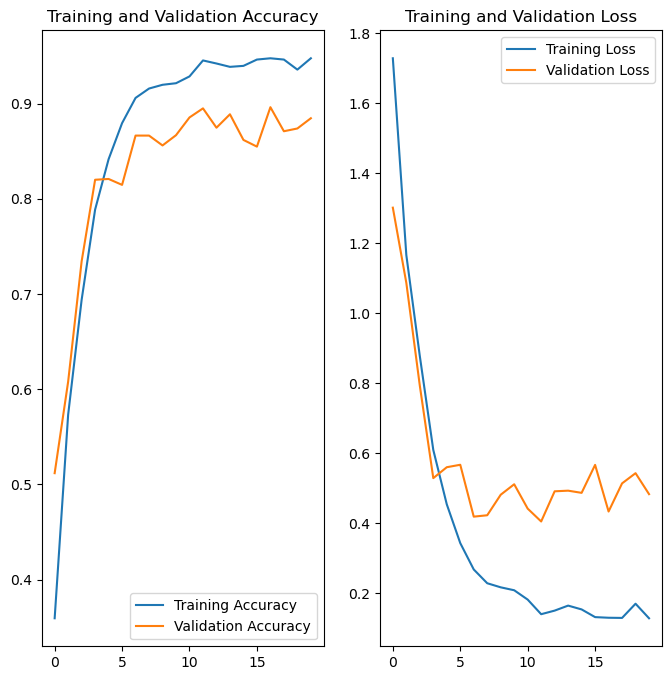

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Class rebalance has significantly improved the overfitting but we have still scope for improving the model as accuracy b/w training & validation datasets still present.